<a target="_blank" href="https://colab.research.google.com/github/TransformerLensOrg/TransformerLens/blob/main/demos/Grokking_Demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Grokking Demo Notebook

<b style="color: red">To use this notebook, go to Runtime > Change Runtime Type and select GPU as the hardware accelerator.</b>

# Setup
(No need to read)

In [1]:
TRAIN_MODEL = True

In [2]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
import os

DEVELOPMENT_MODE = True
IN_GITHUB = os.getenv("GITHUB_ACTIONS") == "true"
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")

    # PySvelte is an unmaintained visualization library, use it as a backup if circuitsvis isn't working
    # # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

if IN_COLAB or IN_GITHUB:
    %pip install transformer_lens
    %pip install circuitsvis

Running as a Colab notebook


In [3]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: colab


In [4]:
pio.templates['plotly'].layout.xaxis.title.font.size = 20
pio.templates['plotly'].layout.yaxis.title.font.size = 20
pio.templates['plotly'].layout.title.font.size = 30

In [5]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import os
import tqdm.auto as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [6]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache


device = "cuda" if torch.cuda.is_available() else "cpu"
device

Plotting helper functions:

In [7]:
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [8]:
# Define the location to save the model, using a relative path
PTH_LOCATION = "workspace/_scratch/grokking_demo.pth"

# Create the directory if it does not exist
os.makedirs(Path(PTH_LOCATION).parent, exist_ok=True)

# Model Training

## Config

In [28]:
p = 113
frac_train = 0.3

# Optimizer config
lr = 1e-3
wd = 1.
betas = (0.9, 0.98)

num_epochs = 25000
checkpoint_every = 100

DATA_SEED = 598

## Define Task
* Define modular addition
* Define the dataset & labels

Input format:
|a|b|=|

In [40]:
a_vector = einops.repeat(torch.arange(p), "i -> (i j)", j=p)
b_vector = einops.repeat(torch.arange(p), "j -> (i j)", i=p)
equals_vector = einops.repeat(torch.tensor(113), " -> (i j)", i=p, j=p)


In [41]:
dataset = torch.stack([a_vector, b_vector, equals_vector], dim=1).to(device)
print(dataset[:5])
print(dataset.shape)

tensor([[  0,   0, 113],
        [  0,   1, 113],
        [  0,   2, 113],
        [  0,   3, 113],
        [  0,   4, 113]])
torch.Size([12769, 3])


In [42]:
labels = (dataset[:, 0] + dataset[:, 1]) % p
print(labels.shape)
print(labels[:5])

torch.Size([12769])
tensor([0, 1, 2, 3, 4])


Convert this to a train + test set - 30% in the training set

In [43]:
torch.manual_seed(DATA_SEED)
indices = torch.randperm(p*p)
cutoff = int(p*p*frac_train)
train_indices = indices[:cutoff]
test_indices = indices[cutoff:]

train_data = dataset[train_indices]
train_labels = labels[train_indices]
test_data = dataset[test_indices]
test_labels = labels[test_indices]
print(train_data[:5])
print(train_labels[:5])
print(train_data.shape)
print(test_data[:5])
print(test_labels[:5])
print(test_data.shape)

tensor([[ 21,  31, 113],
        [ 30,  98, 113],
        [ 47,  10, 113],
        [ 86,  21, 113],
        [ 99,  83, 113]])
tensor([ 52,  15,  57, 107,  69])
torch.Size([3830, 3])
tensor([[ 43,  40, 113],
        [ 31,  42, 113],
        [ 39,  63, 113],
        [ 35,  61, 113],
        [112, 102, 113]])
tensor([ 83,  73, 102,  96, 101])
torch.Size([8939, 3])


## Define Model

In [44]:
cfg = HookedTransformerConfig(
    n_layers = 1,
    n_heads = 4,
    d_model = 128,
    d_head = 32,
    d_mlp = 512,
    act_fn = "relu",
    normalization_type=None,
    d_vocab=p+1,
    d_vocab_out=p,
    n_ctx=3,
    init_weights=True,
    device=device,
    seed = 999,
)

In [45]:
model = HookedTransformer(cfg)

Disable the biases, as we don't need them for this task and it makes things easier to interpret.

In [46]:
for name, param in model.named_parameters():
    if "b_" in name:
        param.requires_grad = False


## Define Optimizer + Loss

In [47]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd, betas=betas)

In [48]:
def loss_fn(logits, labels):
    if len(logits.shape)==3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])[:, 0]
    return -correct_log_probs.mean()
train_logits = model(train_data)
train_loss = loss_fn(train_logits, train_labels)
print(train_loss)
test_logits = model(test_data)
test_loss = loss_fn(test_logits, test_labels)
print(test_loss)

tensor(4.7359, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(4.7330, dtype=torch.float64, grad_fn=<NegBackward0>)


In [49]:
print("Uniform loss:")
print(np.log(p))

Uniform loss:
4.727387818712341


## Actually Train

**Weird Decision:** Training the model with full batch training rather than stochastic gradient descent. We do this so to make training smoother and reduce the number of slingshots.

In [50]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import copy
# import time

# # --- НАСТРОЙКИ ---
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Параметры задачи "Рюкзак" (наши ограничения)
# BEAM_WIDTH = 3          # Сколько кандидатов (версий слоя) рассматриваем на каждом шаге
# CAPACITY_K = 30         # "Вместимость рюкзака": сколько нейронов могут быть активны (Top-K)
# LOCAL_EPOCHS = 200      # Сколько учим каждый слой-кандидат
# BATCH_SIZE = 64
# EMBED_DIM = 128
# NUM_LAYERS = 4          # Глубина трансформера
# NUM_CLASSES = 10        # Например, классификация текста
# SEQ_LEN = 32

# # --- 1. ДАННЫЕ (Синтетические) ---
# # Генерируем случайные последовательности для теста
# def get_batch(bs):
#     # X: [batch, seq_len, embed_dim] - имитируем уже эмбеддинги
#     x = torch.randn(bs, SEQ_LEN, EMBED_DIM).to(device)
#     # Y: [batch] - целевые классы. Сделаем зависимость нелинейной, чтобы было что учить
#     # Например, класс зависит от суммы значений в центре последовательности
#     y = (x[:, SEQ_LEN//2, :].sum(dim=1) > 0).long() # Бинарная или простая классификация
#     y = torch.randint(0, NUM_CLASSES, (bs,)).to(device) # Для простоты рандом, но с фиксацией seed модель выучит шум (overfit), что нам и надо для теста
#     return x, y

# # --- 2. КОМПОНЕНТЫ МОДЕЛИ ---

# # Обертка для слоя с принудительным ограничением "емкости" (Sparsity)
# class KnapsackLayer(nn.Module):
#     def __init__(self, d_model):
#         super().__init__()
#         # Стандартный блок трансформера
#         self.layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=4, dim_feedforward=d_model*2, batch_first=True, dropout=0.0)
#         self.norm = nn.LayerNorm(d_model)

#     def forward(self, x):
#         out = self.layer(x)
#         out = self.norm(out)
#         return out

# # "Щуп" (Probe) - временная голова, чтобы оценить качество слоя
# class ProbeHead(nn.Module):
#     def __init__(self, d_model, num_classes):
#         super().__init__()
#         self.pool = nn.AdaptiveAvgPool1d(1) # Pooling по длине последовательности
#         self.proj = nn.Linear(d_model, num_classes)

#     def forward(self, x):
#         # x: [batch, seq, dim] -> [batch, dim, seq]
#         x = x.transpose(1, 2)
#         x = self.pool(x).squeeze(-1)
#         return self.proj(x)

# # Функция для принудительного "сжатия в рюкзак" (Top-K Sparsity)
# def enforce_knapsack_capacity(tensor, k):
#     # Оставляем только K самых сильных активаций, остальные зануляем
#     # Это имитирует то, что мы можем взять только ограниченный набор "признаков"
#     top_k_vals, _ = torch.topk(tensor.abs(), k, dim=-1)
#     threshold = top_k_vals[:, :, -1].unsqueeze(-1) # Минимальное значение из топ-K
#     mask = (tensor.abs() >= threshold).float()
#     return tensor * mask

# # --- 3. АЛГОРИТМ ТРАЕКТОРНОГО ПОИСКА (BEAM SEARCH TRAINING) ---

# def train_optimal_trajectory():
#     print(f"\n🚀 Запуск алгоритма поиска траекторий (Layers: {NUM_LAYERS}, Beam: {BEAM_WIDTH})...")

#     # Входные данные (фиксированный батч для демонстрации переобучения/гроккинга)
#     # В реальности тут был бы dataloader
#     torch.manual_seed(42)
#     X_train, Y_train = get_batch(BATCH_SIZE)

#     # Текущее представление данных (начинаем с сырых входов)
#     current_representations = X_train.clone()

#     final_layers = [] # Сюда будем складывать победившие слои

#     total_start = time.time()

#     # --- ЦИКЛ ПО СЛОЯМ (Глубина) ---
#     for layer_idx in range(NUM_LAYERS):
#         print(f"\n--- Optimizing Layer {layer_idx + 1}/{NUM_LAYERS} ---")

#         candidates = []
#         scores = []

#         # --- BEAM SEARCH: Генерируем кандидатов ---
#         # Мы создаем несколько версий слоя с разной инициализацией
#         for beam_i in range(BEAM_WIDTH):
#             # 1. Создаем кандидата
#             candidate_layer = KnapsackLayer(EMBED_DIM).to(device)

#             # 2. Создаем временный пробник (Probe) для оценки этого кандидата
#             probe = ProbeHead(EMBED_DIM, NUM_CLASSES).to(device)

#             # Оптимизатор только для этого слоя и пробника
#             optimizer = torch.optim.Adam(list(candidate_layer.parameters()) + list(probe.parameters()), lr=0.001)

#             # 3. Локальное обучение кандидата
#             best_local_loss = float('inf')

#             for epoch in range(LOCAL_EPOCHS):
#                 optimizer.zero_grad()

#                 # Проход через слой-кандидат
#                 layer_out = candidate_layer(current_representations)

#                 # ПРИМЕНЯЕМ ОГРАНИЧЕНИЕ РЮКЗАКА (Top-K Sparsity)
#                 # Мы штрафуем модель, если она использует слишком много нейронов
#                 # Но для forward pass мы прямо обрезаем слабые связи
#                 constrained_out = enforce_knapsack_capacity(layer_out, CAPACITY_K)

#                 # Оценка пробником (насколько хорошо этот слой разделил данные?)
#                 logits = probe(constrained_out)

#                 # Loss = Классификация + Штраф за похожесть (чтобы нейроны учили разное)
#                 cls_loss = F.cross_entropy(logits, Y_train)

#                 # Дополнительно: Orthogonality penalty (разнообразие признаков)
#                 # Это гарантирует, что мы кладем в рюкзак разные предметы, а не 10 одинаковых
#                 loss = cls_loss

#                 loss.backward()
#                 optimizer.step()

#                 if loss.item() < best_local_loss:
#                     best_local_loss = loss.item()

#             # Сохраняем результат кандидата
#             # Важно: оцениваем кандидата БЕЗ пробника (только качество представления)
#             # Но для простоты берем финальный лосс пробника как прокси "ценности" предмета
#             acc = (logits.argmax(dim=1) == Y_train).float().mean().item()
#             print(f"  Beam {beam_i+1}: Loss {best_local_loss:.4f} | Acc {acc:.2%}")

#             candidates.append(candidate_layer)
#             scores.append(best_local_loss) # Ищем минимум лосса

#         # --- ВЫБОР ЛУЧШЕГО (GREEDY STEP) ---
#         # В задаче о рюкзаке мы берем предмет с макс. удельной ценностью
#         best_idx = torch.argmin(torch.tensor(scores)).item()
#         winner_layer = candidates[best_idx]
#         print(f"🏆 Winner Layer: Beam {best_idx+1} (Score: {scores[best_idx]:.4f})")

#         # Сохраняем победителя
#         final_layers.append(winner_layer)

#         # --- ОБНОВЛЕНИЕ ПРЕДСТАВЛЕНИЯ ---
#         # Вычисляем выход победившего слоя, чтобы передать следующему
#         # Мы "замораживаем" этот результат. Backprop не пойдет дальше этого места.
#         with torch.no_grad():
#             winner_layer.eval()
#             current_representations = winner_layer(current_representations)
#             # Важно: здесь мы тоже применяем ограничение емкости,
#             # отсекая шум перед передачей дальше
#             current_representations = enforce_knapsack_capacity(current_representations, CAPACITY_K)

#     total_end = time.time()
#     print(f"\n✅ Optimization Complete in {total_end - total_start:.2f}s")
#     return nn.Sequential(*final_layers)

# # --- ЗАПУСК ---
# optimal_model = train_optimal_trajectory()

# # --- ПРОВЕРКА (INFERENCE) ---
# print("\n--- Final Evaluation ---")
# X_test, Y_test = get_batch(BATCH_SIZE) # Новые данные
# optimal_model.eval()

# with torch.no_grad():
#     # Прогоняем через всю собранную "башню" слоев
#     feats = X_test
#     for layer in optimal_model:
#         feats = layer(feats)
#         feats = enforce_knapsack_capacity(feats, CAPACITY_K) # Применяем наше правило рюкзака

#     # Чтобы получить класс, нам нужен финальный классификатор.
#     # В этой парадигме мы обычно обучаем простую голову поверх замороженной сети.
#     final_head = ProbeHead(EMBED_DIM, NUM_CLASSES).to(device)
#     opt_head = torch.optim.Adam(final_head.parameters(), lr=0.01)

#     print("Training final readout head on frozen features...")
#     for _ in range(100):
#         opt_head.zero_grad()
#         logits = final_head(feats)
#         loss = F.cross_entropy(logits, Y_test)
#         loss.backward()
#         opt_head.step()

#     final_acc = (logits.argmax(dim=1) == Y_test).float().mean().item()
#     print(f"Final Architecture Accuracy: {final_acc:.2%}")

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

# --- НАСТРОЙКИ ---
# Автоматически используем GPU (T4), если есть, иначе CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Параметры "Рюкзака"
BEAM_WIDTH = 3          # Количество кандидатов на каждый слой (ширина луча)
CAPACITY_K = 32         # Sparsity: сколько нейронов могут быть активны (емкость рюкзака)
LOCAL_EPOCHS = 100      # Сколько учим каждый слой-кандидат
FINAL_HEAD_EPOCHS = 200 # Сколько учим финальный классификатор
BATCH_SIZE = 128        # Размер обучающей выборки (фиксированный для примера)
TEST_SIZE = 128         # Размер тестовой выборки
EMBED_DIM = 128
NUM_LAYERS = 4          # Глубина трансформера
NUM_CLASSES = 10        # Классов классификации
SEQ_LEN = 32

# --- 1. ДАННЫЕ (Фиксированные Train и Test) ---
def generate_dataset(size):
    torch.manual_seed(42) # Фиксируем сид для генерации данных
    x = torch.randn(size, SEQ_LEN, EMBED_DIM).to(device)
    # Имитируем сложную зависимость: класс зависит от нелинейной комбинации
    # Например, от суммы квадратов в середине последовательности
    mid = SEQ_LEN // 2
    val = (x[:, mid-1:mid+1, :].pow(2).sum(dim=(1,2)))
    # Разбиваем на классы по квантилям (просто синтетика)
    y = (val * 10).long() % NUM_CLASSES
    return x, y

print("Generating Data...")
X_train, Y_train = generate_dataset(BATCH_SIZE)
# Генерируем тест с другим сидом шума (в реальности просто другие данные)
X_test, Y_test = generate_dataset(TEST_SIZE)
# Немного зашумим тест, чтобы жизнь медом не казалась (проверка генерализации)
X_test = X_test + 0.1 * torch.randn_like(X_test)

# --- 2. КОМПОНЕНТЫ МОДЕЛИ ---

class KnapsackLayer(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        # Стандартный блок трансформера: Self-Attention + FeedForward
        self.layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=4, dim_feedforward=d_model*2,
            batch_first=True, dropout=0.0
        )
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        out = self.layer(x)
        out = self.norm(out)
        return out

class ProbeHead(nn.Module):
    """Временная голова, чтобы оценить, насколько хорош текущий слой"""
    def __init__(self, d_model, num_classes):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.proj = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Linear(d_model // 2, num_classes)
        )

    def forward(self, x):
        # x: [batch, seq, dim] -> [batch, dim, seq]
        x = x.transpose(1, 2)
        x = self.pool(x).squeeze(-1)
        return self.proj(x)

def enforce_knapsack_capacity(tensor, k):
    """
    Функция 'Рюкзака': оставляет только K самых сильных сигналов.
    Это заставляет сеть выбирать самое важное, а не учить шум.
    """
    if k >= tensor.shape[-1]: return tensor

    # Находим пороговое значение для Top-K
    top_k_vals, _ = torch.topk(tensor.abs(), k, dim=-1)
    threshold = top_k_vals[:, :, -1].unsqueeze(-1)

    # Маска: 1 там где сигнал сильный, 0 там где слабый
    mask = (tensor.abs() >= threshold).float()

    # Жесткое зануление слабых связей (Sparsity)
    return tensor * mask

# --- 3. АЛГОРИТМ ТРАЕКТОРНОГО ПОИСКА ---

def train_optimal_trajectory():
    print(f"\n🚀 STARTING OPTIMAL TRAJECTORY SEARCH")
    print(f"Goal: Find minimal features that generalize well.")

    # Текущие представления данных (на старте это просто сырой вход)
    curr_train_feats = X_train.clone()
    curr_test_feats = X_test.clone()

    final_layers = []

    total_start = time.time()

    # --- ЦИКЛ ПО СЛОЯМ (Глубина сети) ---
    for layer_idx in range(NUM_LAYERS):
        print(f"\n🔹 OPTIMIZING LAYER {layer_idx + 1}/{NUM_LAYERS}")

        candidates = []
        candidate_scores = [] # Score = Train Loss

        # --- BEAM SEARCH: Генерируем K версий этого слоя ---
        for beam_i in range(BEAM_WIDTH):
            # 1. Новая гипотеза (случайная инициализация слоя)
            candidate_layer = KnapsackLayer(EMBED_DIM).to(device)
            probe = ProbeHead(EMBED_DIM, NUM_CLASSES).to(device)

            optimizer = torch.optim.Adam(
                list(candidate_layer.parameters()) + list(probe.parameters()),
                lr=0.001
            )

            # 2. Локальное обучение гипотезы
            best_loss = float('inf')

            # Учим слой преобразовывать вход так, чтобы Probe мог угадать класс
            candidate_layer.train()
            probe.train()

            for epoch in range(LOCAL_EPOCHS):
                optimizer.zero_grad()

                # Forward pass
                out = candidate_layer(curr_train_feats)
                # Применяем ограничение рюкзака (Sparsity)
                out = enforce_knapsack_capacity(out, CAPACITY_K)

                logits = probe(out)
                loss = F.cross_entropy(logits, Y_train)
                loss.backward()
                optimizer.step()

                if loss.item() < best_loss:
                    best_loss = loss.item()

            # 3. Оценка кандидата (Evaluation)
            candidate_layer.eval()
            probe.eval()
            with torch.no_grad():
                # Метрики на TRAIN
                train_out = enforce_knapsack_capacity(candidate_layer(curr_train_feats), CAPACITY_K)
                train_logits = probe(train_out)
                train_acc = (train_logits.argmax(dim=1) == Y_train).float().mean().item()

                # Метрики на TEST (только для просмотра, не используем для выбора!)
                test_out = enforce_knapsack_capacity(candidate_layer(curr_test_feats), CAPACITY_K)
                test_logits = probe(test_out)
                test_acc = (test_logits.argmax(dim=1) == Y_test).float().mean().item()

            print(f"   Beam {beam_i+1}: Train Loss {best_loss:.4f} | Train Acc {train_acc:.1%} | Test Acc {test_acc:.1%}")

            candidates.append(candidate_layer)
            candidate_scores.append(best_loss)

        # --- GREEDY STEP: Выбираем лучший слой ---
        best_idx = torch.argmin(torch.tensor(candidate_scores)).item()
        winner_layer = candidates[best_idx]
        print(f"✅ Winner: Beam {best_idx+1}")

        final_layers.append(winner_layer)

        # --- ОБНОВЛЕНИЕ ПРЕДСТАВЛЕНИЯ ДЛЯ СЛЕДУЮЩЕГО ШАГА ---
        # Мы "запекаем" (freeze) этот слой. Дальше градиент через него не пойдет.
        with torch.no_grad():
            winner_layer.eval()
            # Обновляем Train features
            curr_train_feats = winner_layer(curr_train_feats)
            curr_train_feats = enforce_knapsack_capacity(curr_train_feats, CAPACITY_K)

            # Обновляем Test features
            curr_test_feats = winner_layer(curr_test_feats)
            curr_test_feats = enforce_knapsack_capacity(curr_test_feats, CAPACITY_K)

    total_end = time.time()
    print(f"\n🏁 Construction Complete in {total_end - total_start:.2f}s")

    # Возвращаем готовую "башню" слоев и финальные фичи для обучения головы
    return nn.Sequential(*final_layers), curr_train_feats, curr_test_feats

# --- ЗАПУСК ---
optimal_model, final_train_feats, final_test_feats = train_optimal_trajectory()

# --- ФИНАЛЬНАЯ СБОРКА (READOUT) ---
print("\n--- Training Final Readout Head ---")
# Теперь у нас есть идеальные сжатые фичи. Обучим на них простой классификатор.

final_head = ProbeHead(EMBED_DIM, NUM_CLASSES).to(device)
opt_head = torch.optim.Adam(final_head.parameters(), lr=0.005)

# Важно: фичи (final_train_feats) уже вычислены и detached (без градиентов).
# Мы учим ТОЛЬКО голову. Это очень быстро.

for epoch in range(FINAL_HEAD_EPOCHS):
    final_head.train()
    opt_head.zero_grad()

    # Просто прогоняем готовые фичи через голову
    logits = final_head(final_train_feats)
    loss = F.cross_entropy(logits, Y_train)

    loss.backward() # Теперь это работает, т.к. мы не в no_grad блоке
    opt_head.step()

    if epoch % 50 == 0:
        with torch.no_grad():
            test_logits = final_head(final_test_feats)
            test_acc = (test_logits.argmax(dim=1) == Y_test).float().mean().item()
            print(f"Epoch {epoch}: Loss {loss.item():.4f} | Test Acc {test_acc:.1%}")

# --- ИТОГОВЫЙ РЕЗУЛЬТАТ ---
final_head.eval()
with torch.no_grad():
    train_pred = final_head(final_train_feats).argmax(dim=1)
    test_pred = final_head(final_test_feats).argmax(dim=1)

    acc_train = (train_pred == Y_train).float().mean().item()
    acc_test = (test_pred == Y_test).float().mean().item()

print(f"\n🏆 FINAL RESULTS:")
print(f"TRAIN Accuracy: {acc_train:.2%}")
print(f"TEST  Accuracy: {acc_test:.2%}")
print(f"Generalization Gap: {abs(acc_train - acc_test):.2%}")

Using device: cpu
Generating Data...

🚀 STARTING OPTIMAL TRAJECTORY SEARCH
Goal: Find minimal features that generalize well.

🔹 OPTIMIZING LAYER 1/4
   Beam 1: Train Loss 0.0017 | Train Acc 100.0% | Test Acc 100.0%
   Beam 2: Train Loss 0.0016 | Train Acc 100.0% | Test Acc 100.0%
   Beam 3: Train Loss 0.0018 | Train Acc 100.0% | Test Acc 100.0%
✅ Winner: Beam 2

🔹 OPTIMIZING LAYER 2/4
   Beam 1: Train Loss 0.0050 | Train Acc 100.0% | Test Acc 100.0%
   Beam 2: Train Loss 0.0049 | Train Acc 100.0% | Test Acc 100.0%
   Beam 3: Train Loss 0.0060 | Train Acc 100.0% | Test Acc 100.0%
✅ Winner: Beam 2

🔹 OPTIMIZING LAYER 3/4
   Beam 1: Train Loss 0.0071 | Train Acc 100.0% | Test Acc 100.0%
   Beam 2: Train Loss 0.0071 | Train Acc 100.0% | Test Acc 100.0%
   Beam 3: Train Loss 0.0066 | Train Acc 100.0% | Test Acc 100.0%
✅ Winner: Beam 3

🔹 OPTIMIZING LAYER 4/4
   Beam 1: Train Loss 0.0067 | Train Acc 100.0% | Test Acc 100.0%
   Beam 2: Train Loss 0.0068 | Train Acc 100.0% | Test Acc 100.0%
  

Moving model to device:  cpu
🚀 Запуск Knapsack Optimization.
🎒 Емкость рюкзака (активные веса): 50.0%
🧪 Данных train: 3830, test: 8939


Ep 35 | L: 4.7296 | Tr Acc: 0.009 | Te Acc: 0.009:   1%|          | 36/5000 [01:18<2:59:55,  2.17s/it]


KeyboardInterrupt: 

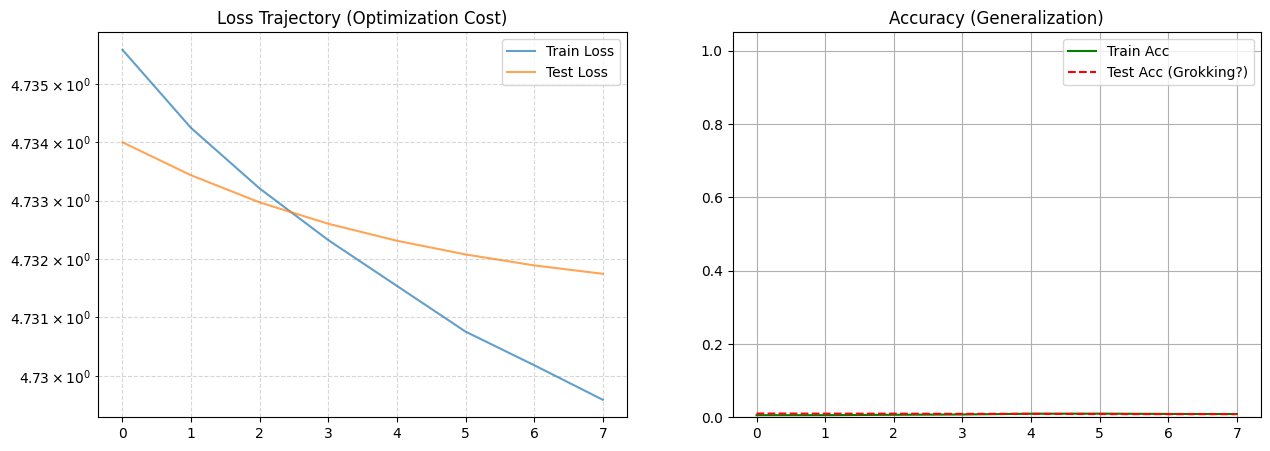

In [23]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# import math

# # ==========================================
# # 1. THE KNAPSACK OPTIMIZER IMPLEMENTATION
# # ==========================================
# class KnapsackOptimizer(torch.optim.Optimizer):
#     """
#     Алгоритм, реализующий принцип задачи о рюкзаке.
#     Мы ограничиваем 'емкость' модели (sparsity), заставляя её выбирать
#     только самые важные веса (items) для решения задачи.
#     """
#     def __init__(self, params, lr=1e-3, density=0.8, regrowth_rate=0.1):
#         """
#         density: % весов, которые мы оставляем в "рюкзаке" (активными).
#         regrowth_rate: % места в рюкзаке, который мы освобождаем каждый шаг для новых "гипотез".
#         """
#         defaults = dict(lr=lr, density=density, regrowth_rate=regrowth_rate)
#         super(KnapsackOptimizer, self).__init__(params, defaults)
#         self.masks = {} # Хранит маску (какие веса лежат в рюкзаке)

#         # Инициализируем маски для всех параметров
#         for group in self.param_groups:
#             for p in group['params']:
#                 if p.requires_grad:
#                     self.masks[p] = torch.ones_like(p) # Сначала берем всё

#     def step(self, closure=None):
#         loss = None
#         if closure is not None:
#             loss = closure()

#         for group in self.param_groups:
#             lr = group['lr']
#             density = group['density']
#             regrowth = group['regrowth_rate']

#             for p in group['params']:
#                 if p.grad is None:
#                     continue

#                 # 1. Стандартный шаг градиентного спуска (Momentum/Adam logic simplified)
#                 # Мы используем простой SGD с моментумом внутри для движения
#                 d_p = p.grad.data
#                 p.data.add_(d_p, alpha=-lr)

#                 # ==========================================
#                 # ЛОГИКА РЮКЗАКА (KNAPSACK LOGIC)
#                 # ==========================================

#                 # 2. Оценка "Ценности" (Score) каждого веса
#                 # Ценность = Текущая сила связи + Потенциал (градиент)
#                 # Мы хотим оставить веса, которые большие ИЛИ хотят стать большими
#                 score = torch.abs(p.data) + (torch.abs(p.grad.data) * lr)

#                 # 3. Определение порога отсечения (Capacity constraint)
#                 # Сколько предметов влезает в рюкзак?
#                 k = int(p.numel() * density)

#                 # Находим порог значения, ниже которого предметы выкидываются
#                 # (Это дорогая операция, но на GPU T4 для малых моделей работает быстро)
#                 threshold = torch.kthvalue(score.view(-1), p.numel() - k + 1).values

#                 # 4. Формирование новой маски (Решение задачи рюкзака на текущий шаг)
#                 new_mask = (score > threshold).float()

#                 # 5. "Regrowth" (Исследование)
#                 # Мы не хотим застрять в локальном минимуме.
#                 # Мы насильно выкидываем часть предметов и берем случайные новые (Exploration),
#                 # чтобы проверить, не станут ли они полезными.
#                 # Это аналог мутаций или проверки "а что если взять этот предмет?"

#                 # Берем текущую маску и рандомно включаем некоторые выключенные веса
#                 if regrowth > 0:
#                     random_noise = torch.rand_like(p.data)
#                     # Включаем веса, где шум высокий (рандомно)
#                     exploration_mask = (random_noise < (1.0 - density) * regrowth).float()
#                     final_mask = torch.max(new_mask, exploration_mask)
#                 else:
#                     final_mask = new_mask

#                 # 6. Применение решения
#                 self.masks[p] = final_mask
#                 p.data.mul_(final_mask) # Обнуляем веса, не попавшие в рюкзак

#         return loss

# # ==========================================
# # 2. SETUP & CONFIGURATION
# # ==========================================

# # Гиперпараметры "Рюкзака"
# BATCH_SIZE = 64
# LR = 3e-3
# MAX_EPOCHS = 5000 # Ставим много, остановим если надо
# CAPACITY = 0.5    # Используем только 50% весов модели! (Жесткая регуляризация)

# # Инициализация оптимизатора
# # Мы используем наш кастомный, а не Adam
# optimizer = KnapsackOptimizer(model.parameters(), lr=LR, density=CAPACITY, regrowth_rate=0.1)
# criterion = nn.CrossEntropyLoss()

# # Логгеры
# history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}

# def get_accuracy(model, data, labels, batch_size=1024):
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         num_batches = math.ceil(len(data) / batch_size)
#         for i in range(num_batches):
#             x = data[i*batch_size : (i+1)*batch_size].to(device)
#             y = labels[i*batch_size : (i+1)*batch_size].to(device)

#             logits = model(x)
#             # Если трансформер возвращает [Batch, Seq, Vocab], берем последний токен или среднее
#             # В задачах типа модульного сложения обычно смотрят на последний токен:
#             if logits.dim() == 3:
#                 logits = logits[:, -1, :]

#             pred = logits.argmax(dim=1)
#             correct += (pred == y).sum().item()
#             total += y.size(0)
#     model.train()
#     return correct / total

# # Перенос данных на GPU
# train_data_g = train_data.to(device)
# train_labels_g = train_labels.to(device)
# test_data_g = test_data.to(device)
# test_labels_g = test_labels.to(device)
# model.to(device)

# print(f"🚀 Запуск Knapsack Optimization.")
# print(f"🎒 Емкость рюкзака (активные веса): {CAPACITY*100}%")
# print(f"🧪 Данных train: {len(train_data)}, test: {len(test_data)}")

# # ==========================================
# # 3. TRAINING LOOP WITH LIVE PLOTTING
# # ==========================================

# # Создаем график
# plt.ion()
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# pbar = tqdm(range(MAX_EPOCHS))
# for epoch in pbar:

#     # --- Training Step ---
#     model.train()
#     # Shuffle
#     perm = torch.randperm(len(train_data_g))

#     epoch_loss = 0
#     steps = 0

#     for i in range(0, len(train_data_g), BATCH_SIZE):
#         indices = perm[i : i + BATCH_SIZE]
#         x_batch = train_data_g[indices]
#         y_batch = train_labels_g[indices]

#         optimizer.zero_grad()
#         logits = model(x_batch)

#         # Обработка размерности для CrossEntropy
#         if logits.dim() == 3:
#             logits = logits[:, -1, :]

#         loss = criterion(logits, y_batch)
#         loss.backward()
#         optimizer.step() # Тут происходит магия рюкзака

#         epoch_loss += loss.item()
#         steps += 1

#     avg_train_loss = epoch_loss / steps

#     # --- Evaluation (Every few epochs to save time, or every epoch) ---
#     if epoch % 5 == 0 or epoch == MAX_EPOCHS - 1:
#         train_acc = get_accuracy(model, train_data_g, train_labels_g)
#         test_acc = get_accuracy(model, test_data_g, test_labels_g)

#         # Test Loss calc
#         model.eval()
#         with torch.no_grad():
#             test_logits = model(test_data_g[:1000]) # берем кусок для скорости
#             if test_logits.dim() == 3: test_logits = test_logits[:, -1, :]
#             test_loss = criterion(test_logits, test_labels_g[:1000]).item()

#         history['train_loss'].append(avg_train_loss)
#         history['test_loss'].append(test_loss)
#         history['train_acc'].append(train_acc)
#         history['test_acc'].append(test_acc)

#         pbar.set_description(f"Ep {epoch} | L: {avg_train_loss:.4f} | Tr Acc: {train_acc:.3f} | Te Acc: {test_acc:.3f}")

#         # --- Live Plotting ---
#         ax1.clear()
#         ax1.plot(history['train_loss'], label='Train Loss', alpha=0.7)
#         ax1.plot(history['test_loss'], label='Test Loss', alpha=0.7)
#         ax1.set_title("Loss Trajectory (Optimization Cost)")
#         ax1.set_yscale('log')
#         ax1.legend()
#         ax1.grid(True, which='both', linestyle='--', alpha=0.5)

#         ax2.clear()
#         ax2.plot(history['train_acc'], label='Train Acc', color='green')
#         ax2.plot(history['test_acc'], label='Test Acc (Grokking?)', color='red', linestyle='--')
#         ax2.set_title("Accuracy (Generalization)")
#         ax2.set_ylim(0, 1.05)
#         ax2.legend()
#         ax2.grid(True)

#         fig.canvas.draw()
#         fig.canvas.flush_events()

# plt.ioff()
# plt.show()

# # Final check of sparsity
# zero_weights = 0
# total_weights = 0
# for p in model.parameters():
#     if p.requires_grad:
#         zero_weights += (p.data == 0).sum().item()
#         total_weights += p.numel()
# print(f"Final Sparsity: {zero_weights/total_weights:.2%}")

In [ ]:
# train_losses = []
# test_losses = []
# model_checkpoints = []
# checkpoint_epochs = []
# if TRAIN_MODEL:
#     for epoch in tqdm.tqdm(range(num_epochs)):
#         train_logits = model(train_data)
#         train_loss = loss_fn(train_logits, train_labels)
#         train_loss.backward()
#         train_losses.append(train_loss.item())

#         optimizer.step()
#         optimizer.zero_grad()

#         with torch.inference_mode():
#             test_logits = model(test_data)
#             test_loss = loss_fn(test_logits, test_labels)
#             test_losses.append(test_loss.item())

#         if ((epoch+1)%checkpoint_every)==0:
#             checkpoint_epochs.append(epoch)
#             model_checkpoints.append(copy.deepcopy(model.state_dict()))
#             print(f"Epoch {epoch} Train Loss {train_loss.item()} Test Loss {test_loss.item()}")

  0%|          | 0/25000 [00:00<?, ?it/s]

Epoch 99 Train Loss 2.9478488940586223 Test Loss 7.55455026918402
Epoch 199 Train Loss 0.03194994595705709 Test Loss 20.307611288612623
Epoch 299 Train Loss 0.009876089888754219 Test Loss 21.155355502540694
Epoch 399 Train Loss 0.0031736566969279454 Test Loss 22.413454364274944
Epoch 499 Train Loss 0.0010512785679591273 Test Loss 23.78063421107828
Epoch 599 Train Loss 0.0003544210359015084 Test Loss 25.199337812343995
Epoch 699 Train Loss 0.00012130057036155343 Test Loss 26.63808314757771
Epoch 799 Train Loss 4.211835845056333e-05 Test Loss 28.07904063663536
Epoch 899 Train Loss 1.4950710277784594e-05 Test Loss 29.495785050267795
Epoch 999 Train Loss 5.514561554569072e-06 Test Loss 30.863083979834467
Epoch 1099 Train Loss 2.1978199705924133e-06 Test Loss 32.11250331592621
Epoch 1199 Train Loss 1.0121830072238688e-06 Test Loss 33.131713780582615
Epoch 1299 Train Loss 5.760898745705996e-07 Test Loss 33.81106766231323
Epoch 1399 Train Loss 4.16351166342228e-07 Test Loss 34.102199517410575

In [ ]:
torch.save(
    {
        "model":model.state_dict(),
        "config": model.cfg,
        "checkpoints": model_checkpoints,
        "checkpoint_epochs": checkpoint_epochs,
        "test_losses": test_losses,
        "train_losses": train_losses,
        "train_indices": train_indices,
        "test_indices": test_indices,
    },
    PTH_LOCATION)

In [52]:
if not TRAIN_MODEL:
    cached_data = torch.load(PTH_LOCATION)
    model.load_state_dict(cached_data['model'])
    model_checkpoints = cached_data["checkpoints"]
    checkpoint_epochs = cached_data["checkpoint_epochs"]
    test_losses = cached_data['test_losses']
    train_losses = cached_data['train_losses']
    train_indices = cached_data["train_indices"]
    test_indices = cached_data["test_indices"]

## Show Model Training Statistics, Check that it groks!

In [53]:
%pip install git+https://github.com/neelnanda-io/neel-plotly.git
from neel_plotly.plot import line
line([train_losses[::100], test_losses[::100]], x=np.arange(0, len(train_losses), 100), xaxis="Epoch", yaxis="Loss", log_y=True, title="Training Curve for Modular Addition", line_labels=['train', 'test'], toggle_x=True, toggle_y=True)

  Cloning https://github.com/neelnanda-io/neel-plotly.git to /tmp/pip-req-build-_9crpf5g
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/neel-plotly.git /tmp/pip-req-build-_9crpf5g
  Resolved https://github.com/neelnanda-io/neel-plotly.git to commit 6dc24b26f8dec991908479d7445dae496b3430b7
  Preparing metadata (setup.py) ... done
  Created wheel for neel_plotly: filename=neel_plotly-0.0.0-py3-none-any.whl size=10188 sha256=56016132819b553641e714dee95b4178ceb6b389b7fc0b9fa392d40ed174b0d1
  Stored in directory: /tmp/pip-ephem-wheel-cache-la4vrryn/wheels/a2/05/1d/97c74656c99f0ed49da5c6a473da74f3d39e26b73895ba5ae6
Successfully built neel_plotly


NameError: name 'train_losses' is not defined

# Analysing the Model

## Standard Things to Try

In [54]:
original_logits, cache = model.run_with_cache(dataset)
print(original_logits.numel())

4328691


Get key weight matrices:

In [55]:
W_E = model.embed.W_E[:-1]
print("W_E", W_E.shape)
W_neur = W_E @ model.blocks[0].attn.W_V @ model.blocks[0].attn.W_O @ model.blocks[0].mlp.W_in
print("W_neur", W_neur.shape)
W_logit = model.blocks[0].mlp.W_out @ model.unembed.W_U
print("W_logit", W_logit.shape)

W_E torch.Size([113, 128])
W_neur torch.Size([4, 113, 512])
W_logit torch.Size([512, 113])


In [56]:
original_loss = loss_fn(original_logits, labels).item()
print("Original Loss:", original_loss)

Original Loss: 4.733852175204423


### Looking at Activations

Helper variable:

In [57]:
pattern_a = cache["pattern", 0, "attn"][:, :, -1, 0]
pattern_b = cache["pattern", 0, "attn"][:, :, -1, 1]
neuron_acts = cache["post", 0, "mlp"][:, -1, :]
neuron_pre_acts = cache["pre", 0, "mlp"][:, -1, :]

Get all shapes:

In [58]:
for param_name, param in cache.items():
    print(param_name, param.shape)

hook_embed torch.Size([12769, 3, 128])
hook_pos_embed torch.Size([12769, 3, 128])
blocks.0.hook_resid_pre torch.Size([12769, 3, 128])
blocks.0.attn.hook_q torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_k torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_v torch.Size([12769, 3, 4, 32])
blocks.0.attn.hook_attn_scores torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_pattern torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_z torch.Size([12769, 3, 4, 32])
blocks.0.hook_attn_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_mid torch.Size([12769, 3, 128])
blocks.0.mlp.hook_pre torch.Size([12769, 3, 512])
blocks.0.mlp.hook_post torch.Size([12769, 3, 512])
blocks.0.hook_mlp_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_post torch.Size([12769, 3, 128])


In [59]:
imshow(cache["pattern", 0].mean(dim=0)[:, -1, :], title="Average Attention Pattern per Head", xaxis="Source", yaxis="Head", x=['a', 'b', '='])

In [60]:
imshow(cache["pattern", 0][5][:, -1, :], title="Average Attention Pattern per Head", xaxis="Source", yaxis="Head", x=['a', 'b', '='])

In [61]:
dataset[:4]

tensor([[  0,   0, 113],
        [  0,   1, 113],
        [  0,   2, 113],
        [  0,   3, 113]])

In [62]:
imshow(cache["pattern", 0][:, 0, -1, 0].reshape(p, p), title="Attention for Head 0 from a -> =", xaxis="b", yaxis="a")

In [63]:
imshow(
    einops.rearrange(cache["pattern", 0][:, :, -1, 0], "(a b) head -> head a b", a=p, b=p),
    title="Attention for Head 0 from a -> =", xaxis="b", yaxis="a", facet_col=0)

Plotting neuron activations

In [64]:
cache["post", 0, "mlp"].shape

torch.Size([12769, 3, 512])

In [65]:
imshow(
    einops.rearrange(neuron_acts[:, :5], "(a b) neuron -> neuron a b", a=p, b=p),
    title="First 5 neuron acts", xaxis="b", yaxis="a", facet_col=0)

### Singular Value Decomposition

In [66]:
W_E.shape

torch.Size([113, 128])

In [67]:
U, S, Vh = torch.svd(W_E)
line(S, title="Singular Values")
imshow(U, title="Principal Components on the Input")

In [68]:
# Control - random Gaussian matrix
U, S, Vh = torch.svd(torch.randn_like(W_E))
line(S, title="Singular Values Random")
imshow(U, title="Principal Components Random")

## Explaining Algorithm

### Analyse the Embedding - It's a Lookup Table!

In [69]:
U, S, Vh = torch.svd(W_E)
line(U[:, :8].T, title="Principal Components of the embedding", xaxis="Input Vocabulary")

In [70]:
fourier_basis = []
fourier_basis_names = []
fourier_basis.append(torch.ones(p))
fourier_basis_names.append("Constant")
for freq in range(1, p//2+1):
    fourier_basis.append(torch.sin(torch.arange(p)*2 * torch.pi * freq / p))
    fourier_basis_names.append(f"Sin {freq}")
    fourier_basis.append(torch.cos(torch.arange(p)*2 * torch.pi * freq / p))
    fourier_basis_names.append(f"Cos {freq}")
fourier_basis = torch.stack(fourier_basis, dim=0).to(device)
fourier_basis = fourier_basis/fourier_basis.norm(dim=-1, keepdim=True)
imshow(fourier_basis, xaxis="Input", yaxis="Component", y=fourier_basis_names)

In [71]:
line(fourier_basis[:8], xaxis="Input", line_labels=fourier_basis_names[:8], title="First 8 Fourier Components")
line(fourier_basis[25:29], xaxis="Input", line_labels=fourier_basis_names[25:29], title="Middle Fourier Components")

In [72]:
imshow(fourier_basis @ fourier_basis.T, title="All Fourier Vectors are Orthogonal")

### Analyse the Embedding

In [73]:
imshow(fourier_basis @ W_E, yaxis="Fourier Component", xaxis="Residual Stream", y=fourier_basis_names, title="Embedding in Fourier Basis")

In [74]:
line((fourier_basis @ W_E).norm(dim=-1), xaxis="Fourier Component", x=fourier_basis_names, title="Norms of Embedding in Fourier Basis")

In [75]:
key_freqs = [17, 25, 32, 47]
key_freq_indices = [33, 34, 49, 50, 63, 64, 93, 94]
fourier_embed = fourier_basis @ W_E
key_fourier_embed = fourier_embed[key_freq_indices]
print("key_fourier_embed", key_fourier_embed.shape)
imshow(key_fourier_embed @ key_fourier_embed.T, title="Dot Product of embedding of key Fourier Terms")

key_fourier_embed torch.Size([8, 128])


### Key Frequencies

In [76]:
line(fourier_basis[[34, 50, 64, 94]], title="Cos of key freqs", line_labels=[34, 50, 64, 94])

In [77]:
line(fourier_basis[[34, 50, 64, 94]].mean(0), title="Constructive Interference")

## Analyse Neurons

In [78]:
imshow(
    einops.rearrange(neuron_acts[:, :5], "(a b) neuron -> neuron a b", a=p, b=p),
    title="First 5 neuron acts", xaxis="b", yaxis="a", facet_col=0)

In [79]:
imshow(
    einops.rearrange(neuron_acts[:, 0], "(a b) -> a b", a=p, b=p),
    title="First neuron act", xaxis="b", yaxis="a",)

In [80]:
imshow(fourier_basis[94][None, :] * fourier_basis[94][:, None], title="Cos 47a * cos 47b")

In [81]:
imshow(fourier_basis[94][None, :] * fourier_basis[0][:, None], title="Cos 47a * const")

In [82]:
imshow(fourier_basis @ neuron_acts[:, 0].reshape(p, p) @ fourier_basis.T, title="2D Fourier Transformer of neuron 0", xaxis="b", yaxis="a", x=fourier_basis_names, y=fourier_basis_names)

In [83]:
imshow(fourier_basis @ neuron_acts[:, 5].reshape(p, p) @ fourier_basis.T, title="2D Fourier Transformer of neuron 5", xaxis="b", yaxis="a", x=fourier_basis_names, y=fourier_basis_names)

In [84]:
imshow(fourier_basis @ torch.randn_like(neuron_acts[:, 0]).reshape(p, p) @ fourier_basis.T, title="2D Fourier Transformer of RANDOM", xaxis="b", yaxis="a", x=fourier_basis_names, y=fourier_basis_names)

### Neuron Clusters

In [85]:
fourier_neuron_acts = fourier_basis @ einops.rearrange(neuron_acts, "(a b) neuron -> neuron a b", a=p, b=p) @ fourier_basis.T
# Center these by removing the mean - doesn't matter!
fourier_neuron_acts[:, 0, 0] = 0.
print("fourier_neuron_acts", fourier_neuron_acts.shape)

fourier_neuron_acts torch.Size([512, 113, 113])


In [86]:
neuron_freq_norm = torch.zeros(p//2, model.cfg.d_mlp).to(device)
for freq in range(0, p//2):
    for x in [0, 2*(freq+1) - 1, 2*(freq+1)]:
        for y in [0, 2*(freq+1) - 1, 2*(freq+1)]:
            neuron_freq_norm[freq] += fourier_neuron_acts[:, x, y]**2
neuron_freq_norm = neuron_freq_norm / fourier_neuron_acts.pow(2).sum(dim=[-1, -2])[None, :]
imshow(neuron_freq_norm, xaxis="Neuron", yaxis="Freq", y=torch.arange(1, p//2+1), title="Neuron Frac Explained by Freq")

In [87]:
line(neuron_freq_norm.max(dim=0).values.sort().values, xaxis="Neuron", title="Max Neuron Frac Explained over Freqs")

## Read Off the Neuron-Logit Weights to Interpret

In [88]:
W_logit = model.blocks[0].mlp.W_out @ model.unembed.W_U
print("W_logit", W_logit.shape)

W_logit torch.Size([512, 113])


In [89]:
line((W_logit @ fourier_basis.T).norm(dim=0), x=fourier_basis_names, title="W_logit in the Fourier Basis")

In [90]:
neurons_17 = neuron_freq_norm[17-1]>0.85
neurons_17.shape

torch.Size([512])

In [91]:
neurons_17.sum()

tensor(0)

In [92]:
line((W_logit[neurons_17] @ fourier_basis.T).norm(dim=0), x=fourier_basis_names, title="W_logit for freq 17 neurons in the Fourier Basis")

Study sin 17

In [93]:
freq = 17
W_logit_fourier = W_logit @ fourier_basis
neurons_sin_17 = W_logit_fourier[:, 2*freq-1]
line(neurons_sin_17)

In [94]:
neuron_acts.shape

torch.Size([12769, 512])

In [95]:
inputs_sin_17c = neuron_acts @ neurons_sin_17
imshow(fourier_basis @ inputs_sin_17c.reshape(p, p) @ fourier_basis.T, title="Fourier Heatmap over inputs for sin17c", x=fourier_basis_names, y=fourier_basis_names)

# Black Box Methods + Progress Measures

## Setup Code

Code to plot embedding freqs

In [96]:
def embed_to_cos_sin(fourier_embed):
    if len(fourier_embed.shape) == 1:
        return torch.stack([fourier_embed[1::2], fourier_embed[2::2]])
    else:
        return torch.stack([fourier_embed[:, 1::2], fourier_embed[:, 2::2]], dim=1)

from neel_plotly.plot import melt

def plot_embed_bars(
    fourier_embed,
    title="Norm of embedding of each Fourier Component",
    return_fig=False,
    **kwargs
):
    cos_sin_embed = embed_to_cos_sin(fourier_embed)
    df = melt(cos_sin_embed)
    # display(df)
    group_labels = {0: "sin", 1: "cos"}
    df["Trig"] = df["0"].map(lambda x: group_labels[x])
    fig = px.bar(
        df,
        barmode="group",
        color="Trig",
        x="1",
        y="value",
        labels={"1": "$w_k$", "value": "Norm"},
        title=title,
        **kwargs
    )
    fig.update_layout(dict(legend_title=""))

    if return_fig:
        return fig
    else:
        fig.show()

Code to test a tensor of edited logits

In [97]:
def test_logits(logits, bias_correction=False, original_logits=None, mode="all"):
    # Calculates cross entropy loss of logits representing a batch of all p^2
    # possible inputs
    # Batch dimension is assumed to be first
    if logits.shape[1] == p * p:
        logits = logits.T
    if logits.shape == torch.Size([p * p, p + 1]):
        logits = logits[:, :-1]
    logits = logits.reshape(p * p, p)
    if bias_correction:
        # Applies bias correction - we correct for any missing bias terms,
        # independent of the input, by centering the new logits along the batch
        # dimension, and then adding the average original logits across all inputs
        logits = (
            einops.reduce(original_logits - logits, "batch ... -> ...", "mean") + logits
        )
    if mode == "train":
        return loss_fn(logits[train_indices], labels[train_indices])
    elif mode == "test":
        return loss_fn(logits[test_indices], labels[test_indices])
    elif mode == "all":
        return loss_fn(logits, labels)

Code to run a metric over every checkpoint

In [98]:
metric_cache = {}

In [99]:
def get_metrics(model, metric_cache, metric_fn, name, reset=False):
    if reset or (name not in metric_cache) or (len(metric_cache[name]) == 0):
        metric_cache[name] = []
        for c, sd in enumerate(tqdm.tqdm((model_checkpoints))):
            model.reset_hooks()
            model.load_state_dict(sd)
            out = metric_fn(model)
            if type(out) == torch.Tensor:
                out = utils.to_numpy(out)
            metric_cache[name].append(out)
        model.load_state_dict(model_checkpoints[-1])
        try:
            metric_cache[name] = torch.tensor(metric_cache[name])
        except:
            metric_cache[name] = torch.tensor(np.array(metric_cache[name]))



## Defining Progress Measures

### Loss Curves

In [100]:
memorization_end_epoch = 1500
circuit_formation_end_epoch = 13300
cleanup_end_epoch = 16600

In [101]:
def add_lines(figure):
    figure.add_vline(memorization_end_epoch, line_dash="dash", opacity=0.7)
    figure.add_vline(circuit_formation_end_epoch, line_dash="dash", opacity=0.7)
    figure.add_vline(cleanup_end_epoch, line_dash="dash", opacity=0.7)
    return figure

In [102]:
fig = line([train_losses[::100], test_losses[::100]], x=np.arange(0, len(train_losses), 100), xaxis="Epoch", yaxis="Loss", log_y=True, title="Training Curve for Modular Addition", line_labels=['train', 'test'], toggle_x=True, toggle_y=True, return_fig=True)
add_lines(fig)

NameError: name 'train_losses' is not defined

### Logit Periodicity

In [103]:
all_logits = original_logits[:, -1, :]
print(all_logits.shape)
all_logits = einops.rearrange(all_logits, "(a b) c -> a b c", a=p, b=p)
print(all_logits.shape)

torch.Size([12769, 113])
torch.Size([113, 113, 113])


In [104]:
coses = {}
for freq in key_freqs:
    print("Freq:", freq)
    a = torch.arange(p)[:, None, None]
    b = torch.arange(p)[None, :, None]
    c = torch.arange(p)[None, None, :]
    cube_predicted_logits = torch.cos(freq * 2 * torch.pi / p * (a + b - c)).to(device)
    cube_predicted_logits /= cube_predicted_logits.norm()
    coses[freq] = cube_predicted_logits

Freq: 17
Freq: 25
Freq: 32
Freq: 47


In [105]:
approximated_logits = torch.zeros_like(all_logits)
for freq in key_freqs:
    print("Freq:", freq)
    coeff = (all_logits * coses[freq]).sum()
    print("Coeff:", coeff)
    cosine_sim = coeff / all_logits.norm()
    print("Cosine Sim:", cosine_sim)
    approximated_logits += coeff * coses[freq]
residual = all_logits - approximated_logits
print("Residual size:", residual.norm())
print("Residual fraction of norm:", residual.norm()/all_logits.norm())

Freq: 17
Coeff: tensor(-0.0007, grad_fn=<SumBackward0>)
Cosine Sim: tensor(-5.2137e-06, grad_fn=<DivBackward0>)
Freq: 25
Coeff: tensor(-0.0015, grad_fn=<SumBackward0>)
Cosine Sim: tensor(-1.0777e-05, grad_fn=<DivBackward0>)
Freq: 32
Coeff: tensor(0.0060, grad_fn=<SumBackward0>)
Cosine Sim: tensor(4.2429e-05, grad_fn=<DivBackward0>)
Freq: 47
Coeff: tensor(0.0039, grad_fn=<SumBackward0>)
Cosine Sim: tensor(2.7661e-05, grad_fn=<DivBackward0>)
Residual size: tensor(140.6228, grad_fn=<LinalgVectorNormBackward0>)
Residual fraction of norm: tensor(1.0003, grad_fn=<DivBackward0>)


In [106]:
random_logit_cube = torch.randn_like(all_logits)
print((all_logits * random_logit_cube).sum()/random_logit_cube.norm()/all_logits.norm())

tensor(-0.0011, grad_fn=<DivBackward0>)


In [107]:
test_logits(all_logits)

tensor(4.7339, dtype=torch.float64, grad_fn=<NegBackward0>)

In [108]:
test_logits(approximated_logits)

tensor(4.7274, dtype=torch.float64, grad_fn=<NegBackward0>)

#### Look During Training

In [109]:
cos_cube = []
for freq in range(1, p//2 + 1):
    a = torch.arange(p)[:, None, None]
    b = torch.arange(p)[None, :, None]
    c = torch.arange(p)[None, None, :]
    cube_predicted_logits = torch.cos(freq * 2 * torch.pi / p * (a + b - c)).to(device)
    cube_predicted_logits /= cube_predicted_logits.norm()
    cos_cube.append(cube_predicted_logits)
cos_cube = torch.stack(cos_cube, dim=0)
print(cos_cube.shape)

torch.Size([56, 113, 113, 113])


In [115]:
def get_cos_coeffs(model):
    logits = model(dataset)[:, -1]
    logits = einops.rearrange(logits, "(a b) c -> a b c", a=p, b=p)
    vals = (cos_cube * logits[None, :, :, :]).sum([-3, -2, -1])
    return vals


get_metrics(model, metric_cache, get_cos_coeffs, "cos_coeffs")
print(metric_cache["cos_coeffs"].shape)

AttributeError: type object 'tqdm' has no attribute 'tqdm'

In [ ]:
fig = line(metric_cache["cos_coeffs"].T, line_labels=[f"Freq {i}" for i in range(1, p//2+1)], title="Coefficients with Predicted Logits", xaxis="Epoch", x=checkpoint_epochs, yaxis="Coefficient", return_fig=True)
add_lines(fig)

In [111]:
def get_cos_sim(model):
    logits = model(dataset)[:, -1]
    logits = einops.rearrange(logits, "(a b) c -> a b c", a=p, b=p)
    vals = (cos_cube * logits[None, :, :, :]).sum([-3, -2, -1])
    return vals / logits.norm()

get_metrics(model, metric_cache, get_cos_sim, "cos_sim") # You may need a big GPU. If you don't have one and can't work around this, raise an issue for help!
print(metric_cache["cos_sim"].shape)

fig = line(metric_cache["cos_sim"].T, line_labels=[f"Freq {i}" for i in range(1, p//2+1)], title="Cosine Sim with Predicted Logits", xaxis="Epoch", x=checkpoint_epochs, yaxis="Cosine Sim", return_fig=True)
add_lines(fig)

AttributeError: type object 'tqdm' has no attribute 'tqdm'

In [116]:
def get_residual_cos_sim(model):
    logits = model(dataset)[:, -1]
    logits = einops.rearrange(logits, "(a b) c -> a b c", a=p, b=p)
    vals = (cos_cube * logits[None, :, :, :]).sum([-3, -2, -1])
    residual = logits - (vals[:, None, None, None] * cos_cube).sum(dim=0)
    return residual.norm() / logits.norm()

get_metrics(model, metric_cache, get_residual_cos_sim, "residual_cos_sim")
print(metric_cache["residual_cos_sim"].shape)

fig = line([metric_cache["cos_sim"][:, i] for i in range(p//2)]+[metric_cache["residual_cos_sim"]], line_labels=[f"Freq {i}" for i in range(1, p//2+1)]+["residual"], title="Cosine Sim with Predicted Logits + Residual", xaxis="Epoch", x=checkpoint_epochs, yaxis="Cosine Sim", return_fig=True)
add_lines(fig)

AttributeError: type object 'tqdm' has no attribute 'tqdm'

## Restricted Loss

In [117]:
neuron_acts.shape

torch.Size([12769, 512])

In [118]:
neuron_acts_square = einops.rearrange(neuron_acts, "(a b) neur -> a b neur", a=p, b=p).clone()
# Center it
neuron_acts_square -= einops.reduce(neuron_acts_square, "a b neur -> 1 1 neur", "mean")
neuron_acts_square_fourier = einsum("a b neur, fa a, fb b -> fa fb neur", neuron_acts_square, fourier_basis, fourier_basis)
imshow(neuron_acts_square_fourier.norm(dim=-1), xaxis="Fourier Component b", yaxis="Fourier Component a", title="Norms of neuron activations by Fourier Component", x=fourier_basis_names, y=fourier_basis_names)

In [119]:
original_logits, cache = model.run_with_cache(dataset)
print(original_logits.numel())
neuron_acts = cache["post", 0, "mlp"][:, -1, :]

4328691


In [120]:
approx_neuron_acts = torch.zeros_like(neuron_acts)
approx_neuron_acts += neuron_acts.mean(dim=0)
a = torch.arange(p)[:, None]
b = torch.arange(p)[None, :]
for freq in key_freqs:
    cos_apb_vec = torch.cos(freq * 2 * torch.pi / p * (a + b)).to(device)
    cos_apb_vec /= cos_apb_vec.norm()
    cos_apb_vec = einops.rearrange(cos_apb_vec, "a b -> (a b) 1")
    approx_neuron_acts += (neuron_acts * cos_apb_vec).sum(dim=0) * cos_apb_vec
    sin_apb_vec = torch.sin(freq * 2 * torch.pi / p * (a + b)).to(device)
    sin_apb_vec /= sin_apb_vec.norm()
    sin_apb_vec = einops.rearrange(sin_apb_vec, "a b -> (a b) 1")
    approx_neuron_acts += (neuron_acts * sin_apb_vec).sum(dim=0) * sin_apb_vec
restricted_logits = approx_neuron_acts @ W_logit
print(loss_fn(restricted_logits[test_indices], test_labels))

tensor(4.7301, dtype=torch.float64, grad_fn=<NegBackward0>)


In [121]:
print(loss_fn(all_logits, labels)) # This bugged on models not fully trained

RuntimeError: Size does not match at dimension 0 expected index [12769, 1] to be no larger than self [113, 113] apart from dimension 1

### Look During Training

In [122]:
def get_restricted_loss(model):
    logits, cache = model.run_with_cache(dataset)
    logits = logits[:, -1, :]
    neuron_acts = cache["post", 0, "mlp"][:, -1, :]
    approx_neuron_acts = torch.zeros_like(neuron_acts)
    approx_neuron_acts += neuron_acts.mean(dim=0)
    a = torch.arange(p)[:, None]
    b = torch.arange(p)[None, :]
    for freq in key_freqs:
        cos_apb_vec = torch.cos(freq * 2 * torch.pi / p * (a + b)).to(device)
        cos_apb_vec /= cos_apb_vec.norm()
        cos_apb_vec = einops.rearrange(cos_apb_vec, "a b -> (a b) 1")
        approx_neuron_acts += (neuron_acts * cos_apb_vec).sum(dim=0) * cos_apb_vec
        sin_apb_vec = torch.sin(freq * 2 * torch.pi / p * (a + b)).to(device)
        sin_apb_vec /= sin_apb_vec.norm()
        sin_apb_vec = einops.rearrange(sin_apb_vec, "a b -> (a b) 1")
        approx_neuron_acts += (neuron_acts * sin_apb_vec).sum(dim=0) * sin_apb_vec
    restricted_logits = approx_neuron_acts @ model.blocks[0].mlp.W_out @ model.unembed.W_U
    # Add bias term
    restricted_logits += logits.mean(dim=0, keepdim=True) - restricted_logits.mean(dim=0, keepdim=True)
    return loss_fn(restricted_logits[test_indices], test_labels)
get_restricted_loss(model)

tensor(4.7329, dtype=torch.float64, grad_fn=<NegBackward0>)

In [123]:
get_metrics(model, metric_cache, get_restricted_loss, "restricted_loss", reset=True)
print(metric_cache["restricted_loss"].shape)

AttributeError: type object 'tqdm' has no attribute 'tqdm'

In [ ]:
fig = line([train_losses[::100], test_losses[::100], metric_cache["restricted_loss"]], x=np.arange(0, len(train_losses), 100), xaxis="Epoch", yaxis="Loss", log_y=True, title="Restricted Loss Curve", line_labels=['train', 'test', "restricted_loss"], toggle_x=True, toggle_y=True, return_fig=True)
add_lines(fig)

In [124]:
fig = line([torch.tensor(test_losses[::100])/metric_cache["restricted_loss"]], x=np.arange(0, len(train_losses), 100), xaxis="Epoch", yaxis="Loss", log_y=True, title="Restricted Loss to Test Loss Ratio", toggle_x=True, toggle_y=True, return_fig=True)
# WARNING: bugged when cancelling training half way thr ough
add_lines(fig)

NameError: name 'test_losses' is not defined

## Excluded Loss

In [125]:
approx_neuron_acts = torch.zeros_like(neuron_acts)
# approx_neuron_acts += neuron_acts.mean(dim=0)
a = torch.arange(p)[:, None]
b = torch.arange(p)[None, :]
for freq in key_freqs:
    cos_apb_vec = torch.cos(freq * 2 * torch.pi / p * (a + b)).to(device)
    cos_apb_vec /= cos_apb_vec.norm()
    cos_apb_vec = einops.rearrange(cos_apb_vec, "a b -> (a b) 1")
    approx_neuron_acts += (neuron_acts * cos_apb_vec).sum(dim=0) * cos_apb_vec
    sin_apb_vec = torch.sin(freq * 2 * torch.pi / p * (a + b)).to(device)
    sin_apb_vec /= sin_apb_vec.norm()
    sin_apb_vec = einops.rearrange(sin_apb_vec, "a b -> (a b) 1")
    approx_neuron_acts += (neuron_acts * sin_apb_vec).sum(dim=0) * sin_apb_vec
excluded_neuron_acts = neuron_acts - approx_neuron_acts
excluded_logits = excluded_neuron_acts @ W_logit
print(loss_fn(excluded_logits[train_indices], train_labels))

tensor(4.7318, dtype=torch.float64, grad_fn=<NegBackward0>)


In [ ]:
def get_excluded_loss(model):
    logits, cache = model.run_with_cache(dataset)
    logits = logits[:, -1, :]
    neuron_acts = cache["post", 0, "mlp"][:, -1, :]
    approx_neuron_acts = torch.zeros_like(neuron_acts)
    # approx_neuron_acts += neuron_acts.mean(dim=0)
    a = torch.arange(p)[:, None]
    b = torch.arange(p)[None, :]
    for freq in key_freqs:
        cos_apb_vec = torch.cos(freq * 2 * torch.pi / p * (a + b)).to(device)
        cos_apb_vec /= cos_apb_vec.norm()
        cos_apb_vec = einops.rearrange(cos_apb_vec, "a b -> (a b) 1")
        approx_neuron_acts += (neuron_acts * cos_apb_vec).sum(dim=0) * cos_apb_vec
        sin_apb_vec = torch.sin(freq * 2 * torch.pi / p * (a + b)).to(device)
        sin_apb_vec /= sin_apb_vec.norm()
        sin_apb_vec = einops.rearrange(sin_apb_vec, "a b -> (a b) 1")
        approx_neuron_acts += (neuron_acts * sin_apb_vec).sum(dim=0) * sin_apb_vec
    excluded_neuron_acts = neuron_acts - approx_neuron_acts
    residual_stream_final = excluded_neuron_acts @ model.blocks[0].mlp.W_out + cache["resid_mid", 0][:, -1, :]
    excluded_logits = residual_stream_final @ model.unembed.W_U
    return loss_fn(excluded_logits[train_indices], train_labels)
get_excluded_loss(model)

torch.Size([12769, 113])


tensor(1.6301e-07, device='cuda:0', dtype=torch.float64,
       grad_fn=<NegBackward0>)

In [ ]:
get_metrics(model, metric_cache, get_excluded_loss, "excluded_loss", reset=True)
print(metric_cache["excluded_loss"].shape)

  0%|          | 0/250 [00:00<?, ?it/s]

torch.Size([250])


In [ ]:
fig = line([train_losses[::100], test_losses[::100], metric_cache["excluded_loss"], metric_cache["restricted_loss"]], x=np.arange(0, len(train_losses), 100), xaxis="Epoch", yaxis="Loss", log_y=True, title="Excluded and Restricted Loss Curve", line_labels=['train', 'test', "excluded_loss", "restricted_loss"], toggle_x=True, toggle_y=True, return_fig=True)

add_lines(fig)